# Term Co-association

In [1]:
import itertools, operator
from pathlib import Path
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from validation.coassoc import *
%matplotlib inline

### Embedding Loading

In [2]:
dir_embeddings = "" # path to folder containing embedding
embedding_name = "" #name of word embedding file 

In [3]:
embedding_path = Path( dir_embeddings ) / embedding_name
embedding = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
vocab = list(embedding.vocab.keys())
print("Loaded embedding %s with %d words" % ( embedding_path.name, len(vocab) ) )

Loaded embedding wikipedia2016-w2v-cbow-d100.bin with 1333306 words


In [4]:
embedding_path # example format of full filepath

PosixPath('/Users/Mark/Desktop/embeddings-w2v/wikipedia2016-w2v-cbow-d100.bin')

In [5]:
def embedding_similarity( term1, term2, embedding):
    """ Method to calculate similarity between two terms based on a given word embedding"""
    try:
        return embedding.similarity( term1, term2 )
    except:
        return 0

### Topic Model Loading

In [6]:
dir_results = "" # path to directory containing topic modeling ranks produced by generate_nmf.py
dataset = "" # folder containing the topic modeling ranks
k = 7
top_terms = 10

In [7]:
kdirname_nmf = "nmf_k%02d" % k
dir_nmf = Path( dir_results ) / dataset / kdirname_nmf

In [8]:
dir_nmf # example format of expected full filepath

PosixPath('/Users/Mark/Desktop/guardian-2009-ranks/nmf_k07')

Load the topic models from the specified directory, and truncate the rankings at the specified number of top terms.

In [9]:
def truncate_term_rankings( orig_rankings, top, vocab = None ):
    """ Method to truncate term rankings to the top t terms, if an embedding vocab
        is provided then this ensures that the terms are part of the vocab """
    
    trunc_rankings = []
    if vocab is None:
        if top < 1:
            return orig_rankings
        for ranking in orig_rankings:
            trunc_rankings.append( ranking[0:min(len(ranking),top)] )
    else:
        total = 0
        for ranking in orig_rankings:
            counter = 0
            temp = []
            for term in ranking:
                if term in vocab:
                    temp.append( term )
                else:
                    counter += 1
                if len(temp) == top:
                    break
            total += counter
            trunc_rankings.append( temp )
    return trunc_rankings

In [10]:
topic_models = []
for fpath in Path(dir_nmf).iterdir():
    if not fpath.stem.startswith("ranks"):
        continue
    (term_rankings,labels) = joblib.load( fpath )
    trunc_rankings = truncate_term_rankings( term_rankings, top_terms, vocab )
    topic_models.append( trunc_rankings )
    
print("Loaded %d topic models from %s" % ( len(topic_models), dir_nmf ) )

Loaded 100 topic models from /Users/Mark/Desktop/guardian-2009-ranks/nmf_k07


### Weighted Coassociation Analysis

Now we will perform weighted coassociation analysis of the topic models we have just loaded:

In [11]:
wco = WeightedCoassociation( embedding, top_terms )

Add all of the models:

In [12]:
for ranking in topic_models:
    wco.add( ranking )

Apply the full matrix building and clustering process:

In [13]:
wco.apply()

In [14]:
# displays the final topics identified by the weighted co-association
for term_cluster in wco.term_clusters:
    print(term_cluster)

['bank', 'banks', 'banking', 'financial', 'government', 'economy', 'tax', 'treasury', 'lloyds', 'bonuses']
['book', 'novel', 'story', 'life', 'books', 'world', 'film', 'love', 'time', 'music']
['league', 'team', 'club', 'season', 'players', 'game', 'manager', 'chelsea', 'liverpool', 'united']
['google', 'microsoft', 'iphone', 'apple', 'windows', 'users', 'internet', 'mobile', 'twitter', 'online']
['company', 'group', 'market', 'shares', 'ftse', 'trading', 'sales', 'price', 'down', 'profits']
['labour', 'party', 'government', 'election', 'mps', 'tory', 'minister', 'cameron', 'brown', 'expenses']
['films', 'movie', 'film', 'movies', 'cinema', 'hollywood', 'actor', 'festival', 'star', 'novel']


### Evaluation

Create a Data Frame of the results. We include the coherence of each cluster, and the least/most coherent pairs in that cluster.

In [15]:
rows = []
for i, term_cluster in enumerate(wco.term_clusters):
    pair_coherences = wco.cluster_pair_coherences[i]
    cluster_coherence = wco.cluster_coherences[i]
    row = { "Cluster" : (i+1) }
    row["Size"] = len( term_cluster )
    row["Top Terms"] = term_cluster
    row["Coherence"] = cluster_coherence
    # best and worst pairs?
    ordered_pair_coherences = sorted(pair_coherences.items(), key=operator.itemgetter(1), reverse=True)
    row["Most Coherent Pair"] = sorted(list(ordered_pair_coherences[0][0]))
    row["Least Coherent Pair"] = sorted(list(ordered_pair_coherences[-1][0]))
    rows.append(row)

Sort the Data Frame in descending order by cluster coherence:

In [16]:
df_clusters = pd.DataFrame(rows, columns=["Cluster","Coherence", "Size","Top Terms","Most Coherent Pair","Least Coherent Pair"])
df_clusters = df_clusters.set_index("Cluster")
df_clusters = df_clusters.sort_values( by="Coherence", ascending=False )
df_clusters

,Coherence,Size,Top Terms,Most Coherent Pair,Least Coherent Pair
Cluster,,,,,
4,0.432011,10,"[google, microsoft, iphone, apple, windows, us...","[google, microsoft]","[online, windows]"
3,0.352251,10,"[league, team, club, season, players, game, ma...","[league, team]","[club, united]"
6,0.303556,10,"[labour, party, government, election, mps, tor...","[government, party]","[expenses, tory]"
1,0.281523,10,"[bank, banks, banking, financial, government, ...","[bank, banks]","[economy, lloyds]"
2,0.251275,10,"[book, novel, story, life, books, world, film,...","[book, novel]","[books, love]"
5,0.232879,10,"[company, group, market, shares, ftse, trading...","[company, group]","[down, ftse]"
7,0.130497,10,"[films, movie, film, movies, cinema, hollywood...","[film, movie]","[novel, star]"


### Cluster Visualization

Firstly, reorder the list of all terms based on the coherence of the clusters, and the term rankings within those clusters:

In [17]:
ordered_terms = []
for i, row in df_clusters.iterrows():
    for term in row["Top Terms"]:
        # avoid duplicates
        if not term in ordered_terms:
            ordered_terms.append( term )

Reorder the rows/columns of all of our pairwise Data Frames:

In [18]:
dfc2 = wco.dfc.reindex(ordered_terms)[ordered_terms]
dfs2 = wco.dfs.reindex(ordered_terms)[ordered_terms]
dfw2 = wco.dfw.reindex(ordered_terms)[ordered_terms]

Define a function for plotting the matrix as a heatmap:

In [21]:
def heatmap( df, width = 20, height = 15, cmap = None, show_cbar = False, font_scale = 1.5 ):
    if cmap is None:
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.set(font_scale=font_scale)
    plt.figure(figsize=(width, height))
    cg = sns.heatmap(df, cmap=cmap, center=0, square=True, vmax=1, linewidths=.1, cbar = show_cbar,  yticklabels=True )
    plt.tight_layout()

Plot the weighted co-association matrix, ordered by cluster:

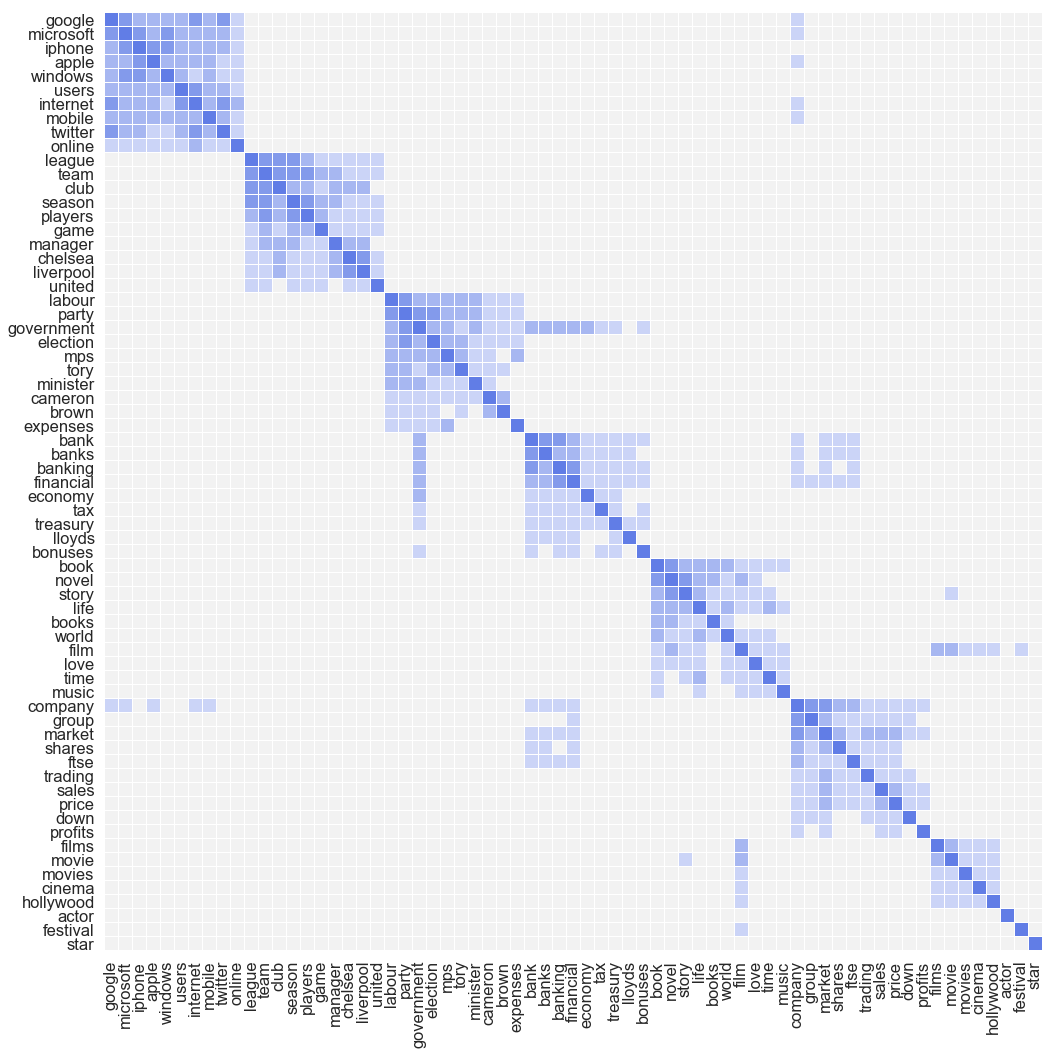

In [22]:
wcmap = sns.diverging_palette(150, 260, s=80, l=55, n=9)
heatmap( dfw2, cmap = wcmap )